# Practical Session 2 - Model Frugality

Welcome to this second practical session of the Frugal AI series. In this sessions we'll delve into the concept of model frugality, and how to build models that are both accurate and efficient while minimizing the resources required to train them.



*During this session you're invited to measure the energy consumption of your code snippets for different models. This is not mandatory as not working on google colab and requiring further configuration on some laptops*


### Energy Consumption Measurements
In the perspective of quantifying the notion of Frugality of our approaches, we'll try to use the library `pyRAPL`to measure the energy consumption of cpus during training times of our different sets of models.
The library isn't compatible with every piece of hardware or OS, if you encounter a problem in using it, just skip this part :)

Try the snippet below to check it out!

### Test of an Energy Consumption estimation snippet

In [ ]:
# Skip energy measurement on Windows - pyRAPL is not compatible
print("Skipping energy measurement - pyRAPL is not compatible with Windows")
print("This is optional and you can proceed with the rest of the notebook")



FileNotFoundError: [Errno 2] No such file or directory: '/sys/devices/system/cpu/present'

# 1 - Dataset Preparation
In this [data folder](https://drive.google.com/drive/folders/1jX4omja8UBcX3MNupX2rLmUJkzR9RhM6?usp=drive_link), you'll find two datasets.

#### Amazon Reviews (6-class classification)
The first one is another extract of the amazon reviews dataset as a six-category classification task. For all classes you have 500 examples that have been pre-selected and split randomly into a classical 80%/10%/10% train/val/test scheme.
Categories that have been kept are the following:
[
    "Beauty",
    "Movies",
    "Appliances",
    "Digital Music",
    "Software",
    "Video_Games"
]

#### WikiText-103-100k

This second dataset is an extract from a known dataset of quality articles from wikipedia called WikiText-103, that comprises high quality articles from wikipedia. Later in the session this extract will allow you to train low-resource embedding models.

In [22]:
import os
import json
import gzip
from typing import List

In [23]:
#1.1 Load the amazon dataset in a variable called split and print the first 5 lines of the train set


path_data_amazon = r"C:\Users\Tyler Marino\OneDrive\Desktop\GradSchool\Saclay\FrugalAI\amazon_reviews"
paths_amazon_splits = {
    key: os.path.join(path_data_amazon, f"{key}.jsonl.gz") for key in ["train", "val", "test"]
}
print(paths_amazon_splits)


def load_jsonl_gz(path):
    with gzip.open(path, "rt", encoding="utf-8") as f:
        for line in f:
            yield json.loads(line)


splits = {key: list(load_jsonl_gz(path)) for key, path in paths_amazon_splits.items()}

print('Training Data')
for i in range(5):
    print(splits["train"][i])

print("Testing Data")
for i in range(5):
    print(splits["test"][i])

{'train': 'C:\\Users\\Tyler Marino\\OneDrive\\Desktop\\GradSchool\\Saclay\\FrugalAI\\amazon_reviews\\train.jsonl.gz', 'val': 'C:\\Users\\Tyler Marino\\OneDrive\\Desktop\\GradSchool\\Saclay\\FrugalAI\\amazon_reviews\\val.jsonl.gz', 'test': 'C:\\Users\\Tyler Marino\\OneDrive\\Desktop\\GradSchool\\Saclay\\FrugalAI\\amazon_reviews\\test.jsonl.gz'}
Training Data
{'review': 'Works great / packaged in box was great too.', 'rating': 4.0, 'category': 'Appliances'}
{'review': 'My personal fav. game of all time.  Bought a 2nd copy as a backup.', 'rating': 5.0, 'category': 'Video_Games'}
{'review': 'I used it to play all day on my sisters death anniversary .', 'rating': 5.0, 'category': 'Digital Music'}
{'review': "I'm so happy to find this game again and in great condition!", 'rating': 5.0, 'category': 'Video_Games'}
{'review': 'Best real news app. NO FAKE NEWS HERE. Tired of liberal bias then check out DRUDGE!', 'rating': 5.0, 'category': 'Software'}
Testing Data
{'review': 'Great quality, very 

['Appliances', 'Video_Games', 'Digital Music', 'Video_Games', 'Software', 'Software', 'Software', 'Video_Games', 'Beauty', 'Software', 'Appliances', 'Appliances', 'Software', 'Video_Games', 'Appliances', 'Movies', 'Beauty', 'Digital Music', 'Digital Music', 'Software', 'Digital Music', 'Movies', 'Beauty', 'Beauty', 'Appliances', 'Movies', 'Movies', 'Beauty', 'Appliances', 'Digital Music', 'Digital Music', 'Appliances', 'Software', 'Video_Games', 'Beauty', 'Video_Games', 'Beauty', 'Software', 'Digital Music', 'Digital Music', 'Software', 'Appliances', 'Video_Games', 'Video_Games', 'Beauty', 'Movies', 'Video_Games', 'Software', 'Video_Games', 'Movies', 'Digital Music', 'Appliances', 'Appliances', 'Video_Games', 'Video_Games', 'Appliances', 'Software', 'Movies', 'Video_Games', 'Software', 'Video_Games', 'Software', 'Software', 'Appliances', 'Beauty', 'Video_Games', 'Software', 'Beauty', 'Digital Music', 'Digital Music', 'Movies', 'Beauty', 'Software', 'Software', 'Appliances', 'Video_Game

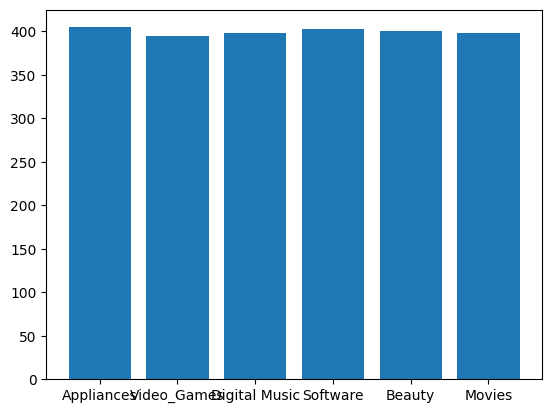

In [24]:
# 1.2 Plot the label distribution of the classes in the training set
# You can copy paste and modify the function you made during the first practical session
import matplotlib.pyplot as plt
import numpy as np
from typing import Any
from collections import Counter


labels = [elem["category"] for elem in splits["train"]]
print(labels)

def plot_distribution_histogram(list_labels: List[Any]):
  """"
    This function creates a bar plot from a counter.

    :param counter: This is a counter object, a dictionary with the item as the key
      and the frequency as the value
    :param ax: an axis of matplotlib
    :return: the axis wit the object in it
    """
  letter_counts = Counter(list_labels)

  frequencies = letter_counts.values()
  names = letter_counts.keys()
  x_coordinates = np.arange(len(letter_counts))
  plot = plt.bar(names, frequencies)
  plt.show()

plot_distribution_histogram(labels)


## 2 - Bag-of-Words Classification Methods

- **BoW** methods are a simple family of methods to represent text data, treating it as a collection of words without considering grammar or word order.
- Each word is mapped to a vector representing word frequencies or occurrences in a document.

In this part we'll study two of those approaches: Naive Bayes classification and TF-IDF classification.

### Advantages
- **Simplicity**: Easy to implement.
- **Efficiency**: Low resources approaches that scale well.
- **Interpretability**: Easy to understand how classification works with word counts.
- **Universal**: Language agnostic and domain agnostic


### Lemmatization and Stop Words Removal in BoW

In BoW, the final feature space is in the size of our number of unique words. To reduce
the size of the feature space by removing the less informative words we usually peform to pre-processing steps: Lemmatization and Stop-words removel

#### 1. Lemmatization or Stemming
- **Definition**: Reducing words to their base or root form (e.g., 'running' to 'run').
- **Why Use It?**: Minimizes redundancy by treating different forms of a word as the same feature, improving model performance.
- **If no ressource are available**: In this context a simple `Stemmer` could be built that would remove common suffixes or prefixes of words such as marks of plurals, conjugations, gender, case endings...


#### 2. Stop Words Removal
- **Definition**: Removing common words (e.g., 'the', 'is') that carry little semantic value.
- **Why Use It?**: Reduces noise, improves computational efficiency, and prevents irrelevant words from influencing the model.
- **If no ressource are available**: A simple stop word list can be created by calculating word frequencies across a corpus, selecting the most frequent and semantically insignificant words, and optionally refining the list manually.

For the lemmatization and the stop word removal we'll use a known library called Spacy. It is available for many languages (See https://spacy.io/usage/models).

We first need to download the english models

In [42]:
pip install -U spacy

Note: you may need to restart the kernel to use updated packages.


In [44]:
! python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------- ------------------------ 5.0/12.8 MB 27.4 MB/s eta 0:00:01
     ---------------------------- ----------- 9.2/12.8 MB 23.8 MB/s eta 0:00:01
     --------------------------------------  12.6/12.8 MB 20.7 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 19.1 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


Below are two code snippets that show you how to use the lemmatizer and the stopword removal functions of spacy

In [45]:
# Here is a code snippet that shows how to use the spaCy lemmatizer

import spacy
# Load the spacy model
nlp = spacy.load("en_core_web_sm")

# Sample text
text = "The cats are running faster than the dogs."

# Process the text
doc = nlp(text)

# Print the lemmas
lemmatized = [token.lemma_ for token in doc]
print(lemmatized)

['the', 'cat', 'be', 'run', 'fast', 'than', 'the', 'dog', '.']


In [19]:
# Here is a code snipppet that shows how to use the spaCy stopwords filter
import spacy

# Load the spacy model
nlp = spacy.load("en_core_web_sm")

# Sample text
text = "The cats are running faster than the dogs."

# Process the text
doc = nlp(text)

# Filter out stop words
filtered_tokens = [token.text for token in doc if not token.is_stop]

print(filtered_tokens)

['cats', 'running', 'faster', 'dogs', '.']


In [25]:
# 2.1 Process the three splits by creating a lemmatized and without stop words version
# Only keep words that are composed of letters, lowercase all the words, and remove accents
# Create entries named lemmatized_no_stopwords in the splits dictionary (see below for the expected output)
#
# splits["train"][0] = {'review': 'Works great / packaged in box was great too.',
#  'rating': 4.0,
#  'category': 'Appliances',
#  'lemmatized_no_stopwords': ['work', 'great', 'package', 'box', 'great']}

# The function to remove accents is supplied below
import unicodedata

def remove_accents(input_str):
    nkfd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nkfd_form if not unicodedata.combining(c)])

def lemmatize_and_remove_stopwords(splits: dict):
    # Load spaCy model once
    global nlp
    try:
        nlp
    except NameError:
        import spacy
        nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "textcat", "attribute_ruler"])

    for split_name in ["train", "val", "test"]:
        if split_name not in splits:
            continue
        entries = splits[split_name]
        texts = [remove_accents(elem["review"]).lower() for elem in entries]

        for doc, elem in zip(nlp.pipe(texts, batch_size=256), entries):
            tokens = [
                tok.lemma_.lower()
                for tok in doc
                if tok.is_alpha and not tok.is_stop
            ]
            elem["lemmatized_no_stopwords"] = tokens

    return splits

splits = lemmatize_and_remove_stopwords(splits)


In [21]:
print(splits['train'][0])

NameError: name 'splits' is not defined

## First Model: Naive Bayes Classification

## Overview
Naive Bayes is a probabilistic classifier based on Bayes' theorem, assuming independence between features. It is particularly effective for text classification tasks.

## Bag of Words Model
The Bag of Words (BoW) model represents text data by converting it into a matrix of token counts. Each document is transformed into a vector where each element corresponds to the frequency of a word in the document.

### Steps:

1. **Text Preprocessing**:
   - Tokenization: Split text into words.
   - Lowercasing: Convert all words to lowercase.
   - Stop-word removal: Eliminate common words (e.g., "and", "the").
   - Stemming/Lemmatization: Reduce words to their root forms.

2. **Vocabulary Creation**:
   - Build a vocabulary of unique words from the training dataset.

3. **Feature Extraction**:
   - Convert documents into vectors based on the vocabulary using count or TF-IDF.

4. **Training the Model**:
   - Calculate prior probabilities for each class:
   
    \begin{align}
     P(Class) = \frac{Count(Class)}{Total\ Count}
    \end{align}
   - Calculate likelihood probabilities:
   
     $$
     P(Word|Class) = \frac{Count(Word \cap Class) + 1}{Count(Class) + V}
     $$
     where $ V $ is the size of the vocabulary (Laplace smoothing).

5. **Classification**:
   - For a new document, compute the posterior probability for each class:
     $$
     P(Class|Document) \propto P(Class) \prod_{i} P(Word_i|Class)
     $$
   - Choose the class with the highest posterior probability.

## Advantages
- Simple and fast.
- Works well with large datasets.
- Handles high dimensionality effectively.

## Disadvantages
- Assumes independence of features.
- May perform poorly with highly correlated features.

## Use Cases
- Spam detection.
- Sentiment analysis.
- Document categorization.

In [14]:
# Here is a code snippet that shows how to use the spaCy lemmatizer

import spacy
# Load the spacy model
nlp = spacy.load("en_core_web_sm")

# Sample text
text = "The cats are running faster than the dogs."

# Process the text
doc = nlp(text)

# Print the lemmas
lemmatized = [token.lemma_ for token in doc]
print(lemmatized)

['the', 'cat', 'be', 'run', 'fast', 'than', 'the', 'dog', '.']


In [17]:
# Here is a code snipppet that shows how to use the spaCy stopwords filter
import spacy

# Load the spacy model
nlp = spacy.load("en_core_web_sm")

# Sample text
text = "The cats are running faster than the dogs."

# Process the text
doc = nlp(text)

# Filter out stop words
filtered_tokens = [token.text for token in doc if not token.is_stop]

print(filtered_tokens)

['cats', 'running', 'faster', 'dogs', '.']


In [16]:
#2.1 Process the three splits by creating a lemmatized and without stop words version
# Only keep words that are composed of letters, lowercase all the words, and remove accents
# Create entries named lemmatized_no_stopwords in the splits dictionary (see below for the expected output)
#
# splits["train"][0] = {'review': 'Works great / packaged in box was great too.',
#  'rating': 4.0,
#  'category': 'Appliances',
#  'lemmatized_no_stopwords': ['work', 'great', 'package', 'box', 'great']}
import unicodedata

def remove_accents(input_str):
    nkfd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nkfd_form if not unicodedata.combining(c)])

def lemmatize_and_remove_stopwords(splits: dict):
    pass
    return splits

# --- Solution

def lemmatize_and_remove_stopwords(splits: dict):
    for split in splits:
        for elem in splits[split]:
            doc = nlp(elem["review"])
            elem["lemmatized_no_stopwords"] = [remove_accents(token.lemma_.lower()) for token in doc if not token.is_stop and token.text.isalpha()]
    return splits

splits = lemmatize_and_remove_stopwords(splits)

NameError: name 'splits' is not defined

## First Model: Naive Bayes Classification

In [26]:
# 2.2 Using CountVectorizer and BernoulliNB from scikit-learn, train a Naive Bayes classifier on the training set
# Complete Naive Bayes Classifier Implementation
import numpy as np
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer

# Create category mappings
category2id = {category: i for i, category in enumerate(np.unique([elem["category"] for elem in splits["train"]]))}
id2category = {i: category for category, i in category2id.items()}

# Initialize CountVectorizer
count_vectorizer = CountVectorizer()

# Extract preprocessed text and labels from training set
train_texts = [" ".join(elem["lemmatized_no_stopwords"]) for elem in splits["train"]]
train_labels = [elem["category"] for elem in splits["train"]]

# Convert labels to integers
y_train = [category2id[label] for label in train_labels]

# Fit CountVectorizer and transform training texts
X_train = count_vectorizer.fit_transform(train_texts)

# Train Naive Bayes classifier
clf_nb = BernoulliNB()
clf_nb.fit(X_train, y_train)

print(f"Training completed! Vocabulary size: {X_train.shape[1]}")
print(f"Number of training samples: {X_train.shape[0]}")
print(f"Categories: {list(category2id.keys())}")


Training completed! Vocabulary size: 3233
Number of training samples: 2400
Categories: [np.str_('Appliances'), np.str_('Beauty'), np.str_('Digital Music'), np.str_('Movies'), np.str_('Software'), np.str_('Video_Games')]


In [71]:
# 2.3 Evaluate the performance of your Naive Bayes classifier on the test set
from sklearn.metrics import classification_report

# Extract preprocessed text and labels from test set
test_texts = [" ".join(elem["lemmatized_no_stopwords"]) for elem in splits["test"]]
test_labels = [elem["category"] for elem in splits["test"]]

# Convert labels to integers using the SAME mapping from training
y_test = [category2id[label] for label in test_labels]

# Transform test texts using the SAME CountVectorizer from training (don't fit again!)
X_test = count_vectorizer.transform(test_texts)

print(classification_report(y_test, clf_nb.predict(X_test), target_names=list(category2id.keys())))

               precision    recall  f1-score   support

   Appliances       0.67      0.80      0.73        45
       Beauty       0.81      0.67      0.74        52
Digital Music       0.85      0.84      0.85        49
       Movies       0.92      0.85      0.88        54
     Software       0.65      0.83      0.73        47
  Video_Games       0.73      0.62      0.67        53

     accuracy                           0.77       300
    macro avg       0.77      0.77      0.77       300
 weighted avg       0.78      0.77      0.77       300



#### TODO

Independently of the energy measurement, how would you quantify the computational and memory complexity of Naive Bayes approach ?
- Express the computation complexity of training as a function of the number of words in the training set
- Express the memory complexity as function of variables of your choice

#### Computational and Memory Complexity Analysis of Naive Bayes

**Training Computational Complexity:**
- **Vocabulary Building**: O(V) where V = total unique words in training set
- **Count Matrix Creation**: O(N × V) where N = number of training documents  
- **Probability Calculation**: O(V × C) where C = number of classes
- **Overall Training**: O(N × V + V × C) = O(N × V) since typically N >> C

**Memory Complexity:**
- **Count Matrix**: O(N × V) - stores word counts for each document
- **Feature Log Probabilities**: O(V × C) - stores log probabilities for each word-class pair
- **Class Priors**: O(C) - stores prior probabilities for each class
- **Overall Memory**: O(N × V + V × C) = O(N × V)

**Key Insights:**
- Complexity scales linearly with training data size (N)
- Vocabulary size (V) is the main bottleneck - larger vocab = more memory/computation
- Very efficient for prediction: O(V) per document
- Memory usage grows quadratically with vocabulary size


In [77]:
# 2.4 Extract top-10 words per class from feature_log_prob_
log_probabilities = clf_nb.feature_log_prob_

# Get vocabulary from count_vectorizer
vocabulary = count_vectorizer.get_feature_names_out()

top_words = {}
for class_idx in range(len(category2id)):
    # Get log probabilities for this class
    class_log_probs = log_probabilities[class_idx]
    
    # Get indices of top 10 words (highest log probabilities)
    top_indices = class_log_probs.argsort()[-10:][::-1]  # Sort descending, take top 10
    
    # Get the actual words
    top_words[class_idx] = [vocabulary[idx] for idx in top_indices]

# Print top words for each class
for class_idx, class_name in id2category.items():
    print(f"\n{class_name} (Class {class_idx}):")
    for i, word in enumerate(top_words[class_idx], 1):
        print(f"  {i:2d}. {word}")


Appliances (Class 0):
   1. work
   2. great
   3. fit
   4. filter
   5. good
   6. easy
   7. coffee
   8. price
   9. like
  10. buy

Beauty (Class 1):
   1. love
   2. great
   3. use
   4. work
   5. hair
   6. like
   7. good
   8. nice
   9. product
  10. look

Digital Music (Class 2):
   1. love
   2. great
   3. cd
   4. music
   5. song
   6. good
   7. album
   8. buy
   9. like
  10. thank

Movies (Class 3):
   1. movie
   2. good
   3. watch
   4. like
   5. great
   6. love
   7. story
   8. time
   9. classic
  10. old

Software (Class 4):
   1. game
   2. play
   3. fun
   4. love
   5. like
   6. good
   7. app
   8. great
   9. time
  10. work

Video_Games (Class 5):
   1. game
   2. love
   3. work
   4. great
   5. good
   6. buy
   7. play
   8. son
   9. price
  10. fun


# Second Model: TF-IDF Classification
TF-IDF, or "Term-frequency - inverse document frequency," is a method used to determine which words are the most discriminative in a text corpus.

It's an approach that can model documents as such.

TF-IDF is a score assigned to a word relative to a document. This score is calculated using two terms:

## TF "term-frequency":

The number of occurrences of the word "cat" in document *i*:

$TF_i(w_{cat}) = count(w_{cat},document_i)$

## IDF "inverse document frequency":

$IDF(w_{cat}) = \frac{\text{Total number of documents in the corpus}}{\text{Number of documents in which cat appears}}$

## Therefore, the TF-IDF of the word "cat" for document *i* is:

$TFIDF_i(w_{cat}) = TF_i(w_{cat}) \cdot IDF(w_{cat})$

We note that the more frequent the word "cat" is in the corpus, the lower its IDF.

Conversely, the more frequent the word "cat" is in document *i*, the higher its TF.

Words with the highest scores for document *i* will be frequent in this document and rare in the corpus, making them adequate to discriminate this type of document!

## Remarks:

Variants exist to limit the size of TF and IDF terms by applying the logarithmic function. We activate one of those variants with the option `sublinear_tf=True`

In [13]:
# 2.5 TF-IDF Implementation and Logistic Regression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Extract preprocessed text from training set
train_texts = [" ".join(elem["lemmatized_no_stopwords"]) for elem in splits["train"]]
train_labels = [elem["category"] for elem in splits["train"]]

# Convert labels to integers using existing mapping
y_train = [category2id[label] for label in train_labels]

# Fit TF-IDF vectorizer and transform training texts
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)

# Extract test data
test_texts = [" ".join(elem["lemmatized_no_stopwords"]) for elem in splits["test"]]
test_labels = [elem["category"] for elem in splits["test"]]
y_test = [category2id[label] for label in test_labels]

# Transform test texts using the fitted TF-IDF vectorizer
X_test_tfidf = tfidf_vectorizer.transform(test_texts)

# Train logistic regression classifier
clf_logistic = LogisticRegression(random_state=0, max_iter=3000)
clf_logistic.fit(X_train_tfidf, y_train)

# Make predictions and print classification report
y_pred = clf_logistic.predict(X_test_tfidf)
print("TF-IDF + Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred, target_names=list(category2id.keys())))

print(f"\nTF-IDF Matrix Shape: {X_train_tfidf.shape}")
print(f"Vocabulary Size: {len(tfidf_vectorizer.get_feature_names_out())}")


NameError: name 'splits' is not defined

In [79]:
# 2.6 Analyze sparsity of TF-IDF matrix
import numpy as np

# Count zero entries in X_train_tfidf
total_elements = X_train_tfidf.shape[0] * X_train_tfidf.shape[1]
zero_elements = X_train_tfidf.nnz  # Number of non-zero elements
sparsity = (total_elements - zero_elements) / total_elements

print(f"TF-IDF Matrix Sparsity Analysis:")
print(f"Matrix shape: {X_train_tfidf.shape}")
print(f"Total elements: {total_elements:,}")
print(f"Non-zero elements: {zero_elements:,}")
print(f"Zero elements: {total_elements - zero_elements:,}")
print(f"Sparsity: {sparsity:.4f} ({sparsity*100:.2f}%)")
print(f"Density: {1-sparsity:.4f} ({(1-sparsity)*100:.2f}%)")

# Compare with CountVectorizer sparsity
count_sparsity = (X_train.shape[0] * X_train.shape[1] - X_train.nnz) / (X_train.shape[0] * X_train.shape[1])
print(f"\nCountVectorizer Sparsity: {count_sparsity:.4f} ({count_sparsity*100:.2f}%)")
print(f"TF-IDF is {'more' if sparsity > count_sparsity else 'less'} sparse than CountVectorizer")


TF-IDF Matrix Sparsity Analysis:
Matrix shape: (2400, 3273)
Total elements: 7,855,200
Non-zero elements: 15,454
Zero elements: 7,839,746
Sparsity: 0.9980 (99.80%)
Density: 0.0020 (0.20%)

CountVectorizer Sparsity: 0.9980 (99.80%)
TF-IDF is less sparse than CountVectorizer


Testing different numbers of SVD components:
--------------------------------------------------
Components:   8 | F1-macro: 0.4864
Components:  16 | F1-macro: 0.5752
Components:  32 | F1-macro: 0.5866
Components: 128 | F1-macro: 0.6851
Components: 256 | F1-macro: 0.6780


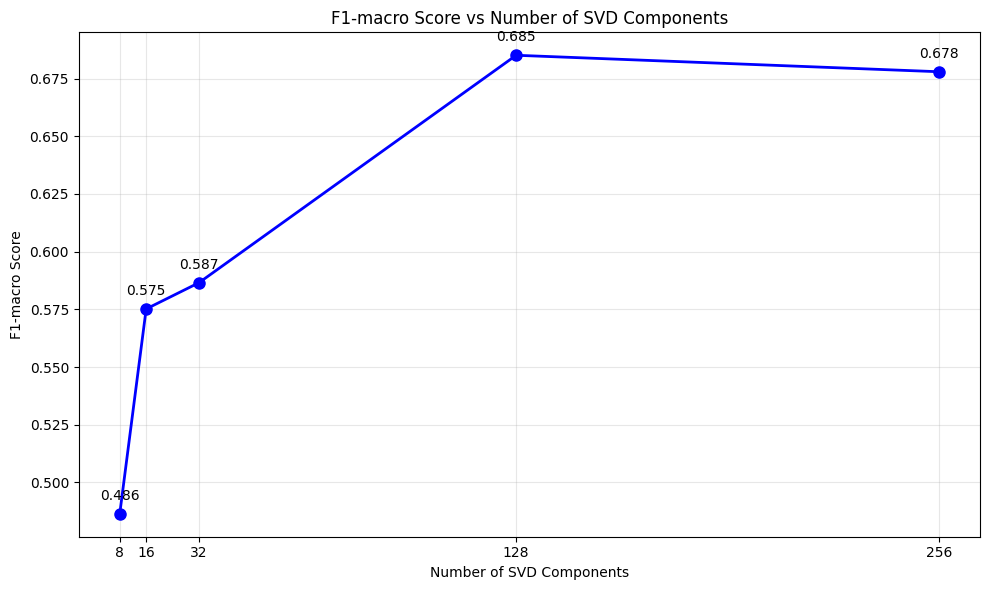


Best performance: 0.6851 with 128 components


In [80]:
# 2.7 Truncated SVD Analysis with Different Components
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Test different numbers of components
components = [8, 16, 32, 128, 256]
f1_scores = []

print("Testing different numbers of SVD components:")
print("-" * 50)

for n in components:
    # Create TruncatedSVD
    svd = TruncatedSVD(n_components=n, n_iter=50, random_state=42)
    
    # Fit SVD on training data
    X_train_svd = svd.fit_transform(X_train_tfidf)
    
    # Transform test data
    X_test_svd = svd.transform(X_test_tfidf)
    
    # Train logistic regression
    clf_svd = LogisticRegression(random_state=0, max_iter=3000)
    clf_svd.fit(X_train_svd, y_train)
    
    # Make predictions and calculate F1 score
    y_pred_svd = clf_svd.predict(X_test_svd)
    f1_macro = f1_score(y_test, y_pred_svd, average='macro')
    f1_scores.append(f1_macro)
    
    print(f"Components: {n:3d} | F1-macro: {f1_macro:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(components, f1_scores, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of SVD Components')
plt.ylabel('F1-macro Score')
plt.title('F1-macro Score vs Number of SVD Components')
plt.grid(True, alpha=0.3)
plt.xticks(components)

# Add value labels on points
for i, (x, y) in enumerate(zip(components, f1_scores)):
    plt.annotate(f'{y:.3f}', (x, y), textcoords="offset points", 
                xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

print(f"\nBest performance: {max(f1_scores):.4f} with {components[f1_scores.index(max(f1_scores))]} components")


### Todo

What can you say about the sparsity of X_train? (2-3 sentences)


## Latent Semantic Indexing (LSI): An extension of TF-IDF

If you know PCA (Principal Component Analysis), or its equivalent SVD (Singular Value Decomposition), we can extract axes that explain the most the variability of our data. We can thus truncate and densify the representation by only keeping the k axes that explain the most the data variability.

This approach of dimensionality reduction is called Truncated Singular Value Decomposition.

<img src="https://www.researchgate.net/profile/Jila-Ayubi/publication/271076899/figure/fig1/AS:614261244051470@1523462701842/Singular-value-decomposition-of-A-a-full-rank-r-b-rank-k-approximation.png">

In [ ]:
# 2.7 Truncate the svd for different number of components and fit a logistic regression model
# Plot the evolution of f1_macro function of the number of components
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

for n in [8,16,32,128,256]:
    svd = TruncatedSVD(n_components=n, n_iter=50, random_state=42)

    X_train = None # TODO: modify

    svd.fit(X_train)

    # Your code here



In [ ]:
# 2.8 Plot the confusion matrix for the smallest and highest number of component
# Below a code to plot the confusion matrix

from sklearn.metrics import confusion_matrix

import seaborn as sns

# Plot confusion matrix
import matplotlib.pyplot as plt



# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = [id2category[i] for i in range(6)]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=np.arange(len(labels))+0.5, labels=labels)
plt.yticks(ticks=np.arange(len(labels))+0.5, labels=labels, rotation=0)
plt.show()


#### TODO

Do you note anything between the two confusion matrices? (1-2 sentences)

# Train your TF-IDF on wikipedia

Sometimes the quantity of data available isn't sufficient to actually build interesting tf-idf representations.

In those case one can try to learn the idf coefficients through the use of another big corpus.

Here we're going to do it through the use of a corpus of 100k paragraphs from 103 articles.


### Todo

Explain why the dataset is not ideal? (2-3 sentences)

In [42]:
# 2.9 learn a tf-idf on wiki-103

#TODO: Modify with your path
path_wikipedia = "wikitext-103/wiki-103-extract-100k.jsonl.gz"

# You can pass a generator to the fit() method to not overload your ram memory
text_generator = (json.loads(line)["text"] for line in gzip.open(path_wikipedia, "rt"))

tfidf = TfidfVectorizer(sublinear_tf=True, max_df = 0.8, min_df=10, norm='l2')

# Your code here
tfidf.fit(text_generator)

# Optionally inspect the vocabulary size
print(f"Vocabulary size: {len(tfidf.vocabulary_):,}")
print("Example terms:", list(tfidf.vocabulary_.keys())[:10])
list(tfidf.vocabulary_.items())[:10]

Vocabulary size: 36,420
Example terms: ['adolf', 'hitler', 'rise', 'power', 'germany', 'his', 'regime', 'anti', 'semitic', 'policies']


[('adolf', 2288),
 ('hitler', 16344),
 ('rise', 28224),
 ('power', 25570),
 ('germany', 14734),
 ('his', 16323),
 ('regime', 27329),
 ('anti', 3207),
 ('semitic', 29488),
 ('policies', 25312)]

In [41]:
# 2.10 transform your training set, learn a logistic regression classifier and plot the classification_report
from sklearn.model_selection import train_test_split
# -------------------------------
# 2️⃣ Split into train / test sets
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# -------------------------------
# 3️⃣ Fit the TF-IDF on training text
# -------------------------------
tfidf = TfidfVectorizer(sublinear_tf=True, max_df=0.8, min_df=10, norm="l2")
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"TF-IDF vocabulary size: {len(tfidf.vocabulary_):,}")

# -------------------------------
# 4️⃣ Train logistic regression
# -------------------------------
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)

# -------------------------------
# 5️⃣ Evaluate performance
# -------------------------------
y_pred = clf.predict(X_test_tfidf)
report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

# -------------------------------
# 6️⃣ Plot the classification report
# -------------------------------
sns.heatmap(
    pd.DataFrame(report).iloc[:-1, :].T,
    annot=True,
    cmap="Blues",
    fmt=".2f"
)
plt.title("Classification Report (Logistic Regression on WikiText TF-IDF)")
plt.show()


NameError: name 'texts' is not defined

# 3 - Word Embeddings: Fasttext and Word2Vec

FastText and Word2Vec are two popular algorithms for generating word embeddings, which are dense vector representations of words in a continuous vector space. There's also a third popular algorithm called GloVe, which we'll not cover in this session, as is very different from the two others.

Those two models exist in two flavors: Skip-gram and Continuous Bag of Words (CBOW). The main difference between the two is the way they are trained. Skip-gram predicts context words from a target word, while CBOW predicts the target word based on its context.

![word2vec](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*cuOmGT7NevP9oJFJfVpRKA.png)

## Word2Vec
- **Training**: Trains using Skip-gram or Continuous Bag of Words (CBOW) models. It converts words into dense vectors based on their context within a window.
  - **Skip-gram**: Predicts context words from a target word.
  - **CBOW**: Predicts the target word based on its context.

## FastText
- **Training**: Also supports Skip-gram and CBOW. Key difference: it represents words as a bag of character **n-grams**.
  - Instead of mapping each word directly, it breaks words into subword units, helping with rare words and morphology.

## Similarities
- Both use Skip-gram and CBOW.
- Both output dense word vectors.
- Both leverage surrounding context in training.

## Differences
- **FastText**: Uses subword information (character n-grams), improving performance with rare/unknown words.
- **Word2Vec**: Treats each word as a single entity, making it less effective for rare words or inflectional languages.

In FastText word representations are thus computed as the average of the representations of its character n-grams.
Example: The word `elephant` can be represented as the sum of its character n-grams `'<elep', 'eleph', 'lepha', 'ephan', 'phant', 'hant>'`.


## FastText in Supervised Setting

FastText can be also be trained in supervised settings such as text classification. In a supervised setting, it learns word and sentence representations while simultaneously training a classifie

In this part we'll only use fasttext in unsupervised setting by using the model pretrained on wikipedia

In [ ]:
# 3.1 Load the fasttext model cc.en.300.bin
import fasttext

# Your code here

In [ ]:
# 3.2 Using the get_sentence_vector() method add for each entry of split its sentence vector representation from a lemmatized without stopwords version of the review. Add the representation in a field "fasttext_wiki" for each entry

for split in splits.keys():
    for elem in splits[split]:
        # Your code here
        pass

In [ ]:
# 3.3 Train a logistic regression model and print its classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

y_test, y_pred = None
clf_logistic = LogisticRegression(random_state=0, max_iter=3000)

# Your code here

print(classification_report(y_test, y_pred))

### Todo
Explain to what extent fasttext representations are expected to be better than tf-idf ones on wikipedia?

Explain to what extent they're expected to be less relevant too?

(2-3 sentences)

### Weighted Fasttext:

We can try to make use of the best of both worlds by using the idf coefficient to weight the sum of our fasttext features.

In [ ]:
# Below we supply some functions to compute average representations using Fasttext and IDF coefficients
import numpy as np


def get_idf_coefs(words, tfidf):
    """
    Given a tf-idf model, this functions only return the words that have an entry in the tf-idf matrix
    It also return their associated idf coefficients
    """
    indices = [tfidf.vocabulary_.get(word) for word in words]
    filtered_words = [words[i] for i in range(len(words)) if indices[i] is not None]
    idf_coefs = [tfidf.idf_[i] for i in indices if not(i is None)]
    return filtered_words, idf_coefs

def average_word_vectors(model, words, idf_coefs = None):
    """
    This function computes the average word vector of a list of words.
    If no idf_coefs are provided, it computes the simple average.
    If idf_coefs are provided, it computes the weighted average.
    """
    word_vectors = [model.get_word_vector(word) for word in words]
    if not(idf_coefs is None):
        # Your code here
        # The list of coefs should be normalized to sum to 1 using the method of your choice
        return None
    else:
        return np.average(word_vectors, axis=0)


In [1]:
# 3.4 Make idf weighted average representation in splits called `weighted_fasttext`
# For reviews that don't have any words in the tf-idf model, use the simple average representation

In [2]:
# 3.5 Train a logistic regression model and print its classification_report

### Todo

Are the results as expected? (1-2 sentences)

## 4 - Tiny Bert (Bonus part)

In this part we concentrate on the use of a pretrained encoder-model composed of two BertEncoder layers.

We're going to perform finetuning of this model in two settings (full-finetuning and Lora finetuning (which is related to dimensionality reduction))

In [11]:
from typing import List


In [7]:
# Load the model of interest
from transformers import AutoModel, AutoTokenizer
bert_model = AutoModel.from_pretrained("prajjwal1/bert-tiny")
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")

config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

c:\Users\Tyler Marino\onedrive\desktop\gradschool\saclay\signalprocessing\sp_venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Tyler Marino\.cache\huggingface\hub\models--prajjwal1--bert-tiny. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' packa

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [8]:
# Below we supply two classes, one for the head classification and one for the full model
import torch

class HeadClassification(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        input_dim: size of hidden layer (pooled_output)
        output_dim: number of classes
        """
        super(HeadClassification, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """
        x: tensor of shape (batch_size, input_dim)
        return unnormalized logits of shape (batch_size, output_dim)
        """
        return self.linear(x)


class BertForClassification(torch.nn.Module):
    def __init__(self, bert, input_dim, output_dim):
        """
        bert: bert model
        output_dim: number of classes
        """
        super(BertForClassification, self).__init__()
        self.bert = bert
        self.input_dim = input_dim
        self.classifier = HeadClassification(self.input_dim, output_dim)

    def forward(self, input_ids, attention_mask, **kwargs):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        return logits


model.safetensors:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

In [31]:
print(X_train)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 15447 stored elements and shape (2400, 3233)>
  Coords	Values
  (0, 3186)	1
  (0, 1264)	2
  (0, 2011)	1
  (0, 307)	1
  (1, 2071)	1
  (1, 1030)	1
  (1, 1173)	1
  (1, 2903)	1
  (1, 367)	1
  (1, 603)	1
  (1, 189)	1
  (2, 2119)	1
  (2, 692)	1
  (2, 2596)	1
  (2, 698)	1
  (2, 108)	1
  (3, 1264)	1
  (3, 1173)	1
  (3, 1306)	1
  (3, 1062)	1
  (3, 569)	1
  (4, 1233)	1
  (4, 2280)	1
  (4, 1906)	2
  (4, 121)	1
  :	:
  (2396, 274)	1
  (2397, 367)	1
  (2397, 399)	1
  (2397, 3045)	1
  (2397, 3137)	1
  (2397, 190)	1
  (2397, 1019)	1
  (2397, 1326)	1
  (2397, 2091)	1
  (2397, 1538)	4
  (2397, 1597)	1
  (2398, 1897)	1
  (2398, 3078)	1
  (2398, 1633)	1
  (2398, 486)	1
  (2398, 1383)	1
  (2398, 2773)	1
  (2399, 2193)	1
  (2399, 780)	1
  (2399, 2967)	1
  (2399, 1904)	1
  (2399, 515)	1
  (2399, 1543)	1
  (2399, 963)	1
  (2399, 1634)	1


In [29]:
# Below we supply two classes, this time for the dataset and dataloader in pytorch
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MyDataset(Dataset):
    def __init__(self, X: List[np.array], y: List[int]):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class Datacollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer


    def __call__(self, inputs):
        X = [elem[0] for elem in inputs]
        y = [elem[1] for elem in inputs]
        batch = self.tokenizer.batch_encode_plus(  # <-- use self.tokenizer
            X,
            return_tensors="pt",
            padding="longest"
        )
        labels = torch.tensor(y)

        # batch = tokenizer.batch_encode_plus(X, return_tensors="pt", padding="longest")
        # labels = torch.tensor(y)
        return batch, labels


# Create the dataset
dataset = MyDataset(X_train, y_train)

data_collator = Datacollator(tokenizer)

# Create the dataloader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
f

TypeError: sparse array length is ambiguous; use getnnz() or shape[0]

In [ ]:
class LinearWarmupScheduler:
    """
    This class implements a usual learning rate scheduling with warmups steps followed by linear decay of the learning rate after each `scheduler.step()` calls
    """
    def __init__(self, optimizer, warmup_steps, training_steps):
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.training_steps = training_steps

    def __call__(self, current_step: int):
        return self.warmup(current_step)

    def warmup(self, current_step: int):
        if current_step < self.warmup_steps:  # current_step / warmup_steps * base_lr
            return float(current_step / self.warmup_steps)
        else:                                 # (num_training_steps - current_step) / (num_training_steps - warmup_steps) * base_lr
            return max(0.0, float(self.training_steps - current_step) / float(max(1, self.training_steps - self.warmup_steps)))



In [ ]:
# 4.1 Load the validation dataloader

In [ ]:
# 4.2 Complete the training loop
# Save the model that has the best validation loss after an epoch
# You can use `best_model` = copy.deepcopy(model)
from sklearn.metrics import f1_score
import torch.nn as nn
import torch.optim as optim
import copy
best_val_loss = float('inf')
epochs_without_improvement = 0
patience = 8  # Number of epochs with no improvement after which training will be stopped
num_epochs = 40
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
best_model = None

### TODO: Modify

classification_model = None
train_loader = None
val_loader= None

###



optimizer = optim.Adam(classification_model.parameters(), lr=learning_rate)


training_steps = len(train_loader) * num_epochs
linearwarmup_func =  LinearWarmupScheduler(optimizer, warmup_steps=int(0.1*training_steps), training_steps=int(training_steps))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=linearwarmup_func)

for epoch in range(num_epochs):
    # Training phase
    classification_model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = classification_model.forward(**inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    print(f"Epoch {epoch}, Learning Rate: {optimizer.param_groups[0]['lr']}")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}")

    # Validation phase
    validation_loss = 0
    y_pred = []
    y_true = []
    with torch.no_grad():
        classification_model.eval()
        for inputs, labels in val_loader:
            y_true += labels.squeeze().tolist()
            outputs =  classification_model.forward(**inputs)
            predictions = torch.argmax(outputs, dim=1)
            y_pred += predictions.squeeze().tolist()
            validation_loss += criterion(outputs, labels).item()
        f1_macro = f1_score(y_true, y_pred, average="macro")
        print(f"F1 Score (Macro): {f1_macro:.4f}")
    validation_loss /= len(val_loader)

    # Early stopping check
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {validation_loss:.4f}")
    if validation_loss < best_val_loss:
        best_val_loss = validation_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1}. No improvement for {patience} epochs.")
        break

In [ ]:
# 4.3 Measure the model performance using the classification_report
from sklearn.metrics import classification_report

# Your code here

## Reducing the computational and memory complexity of transformer finetuning
### LoRA (Low-Rank Adaptation) for Transformer Fine-tuning

LoRA is a technique to reduce the number of trainable parameters during fine-tuning by injecting trainable low-rank matrices into the pre-trained model's weight matrices. Instead of updating the entire weight matrix, LoRA introduces low-rank factorization.


![lora](https://www.researchgate.net/profile/Ruibo-Fu/publication/371490294/figure/fig1/AS:11431281167009019@1686539371648/Transformer-architecture-in-wav2vec2-along-with-LoRA.png)


#### Key Concepts:

- **Rank (r):** The rank of the factorized matrices. It controls the dimensionality of the introduced low-rank matrices. A lower rank reduces the trainable parameters but may limit the model's capacity.
  
- **Alpha (α):** A scaling factor applied to the learned low-rank matrices before they are added to the original weight matrix. It controls how much influence the low-rank matrices have.

LoRA fine-tunes transformers efficiently with fewer trainable parameters by modifying only the low-rank matrices.


In [ ]:
# Below is a manual implementation of LoRa where each BerEncoder layer is changed into its LoRa version
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer

class LoRALayer(nn.Module):
    def __init__(self, original_layer, r=4, alpha=16):
        super().__init__()
        self.original_layer = original_layer
        self.r = r
        self.alpha = alpha

        # Set requires_grad to False for the original layer
        for param in self.original_layer.parameters():
            param.requires_grad = False

        # Initialize LoRA components
        self.lora_A = nn.Parameter(torch.randn(original_layer.weight.size(0), r))
        self.lora_B = nn.Parameter(torch.randn(r, original_layer.weight.size(1)))
        self.scaling = alpha / r

        # Optional: Initialize LoRA matrices to zero to not affect the original layer at the start
        nn.init.zeros_(self.lora_A)
        nn.init.zeros_(self.lora_B)

    def forward(self, x):
        # Original layer output
        original_output = self.original_layer(x)

        # LoRA output: Adding scaled low-rank matrices' contribution
        lora_output = (x @ self.lora_B.T) @ self.lora_A.T
        lora_output *= self.scaling

        return original_output + lora_output

class BertWithLoRA(nn.Module):
    def __init__(self, model_name='prajjwal1/bert-tiny', r=8, alpha=16):
        super().__init__()
        # Load the pre-trained BERT model
        self.bert = BertModel.from_pretrained(model_name)

        # Freeze all parameters in the model
        for param in self.bert.parameters():
            param.requires_grad = False

        # Apply LoRA to the last encoder layer's attention projection (e.g., output layer of the last attention head)
        for layer in self.bert.encoder.layer:
            attention_head = layer.attention.self
            layer.attention.self.query = LoRALayer(attention_head.query, r, alpha)
            layer.attention.self.key = LoRALayer(attention_head.key, r, alpha)
            layer.attention.self.value = LoRALayer(attention_head.value, r, alpha)
            layer.attention.output.dense = LoRALayer(layer.attention.output.dense, r, alpha)

    def forward(self, input_ids, attention_mask=None):
        return self.bert(input_ids=input_ids, attention_mask=attention_mask)


In [ ]:
# 4.4 Re-implement the training loop but using the Lora augmented model

In [ ]:
# 4.5 Using the classification_report function compare the performances of the two models

#### Todo

What are your explanations for this underperforming of transformer models compared to much lighter approaches in this practical session?